In [106]:
# 1 for positive, 0 for negative, negative is 3 stars or less
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from imblearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
import gensim
import nltk
from nltk.tokenize import word_tokenize
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import seaborn as sns
import string
import joblib

from IPython.core.interactiveshell import InteractiveShell 
InteractiveShell.ast_node_interactivity = "all"
import warnings
warnings.filterwarnings('ignore')

stopwords = pd.read_csv("./Data/stop_words.csv")
stopwords=[i.replace('"',"").strip() for i in stopwords.columns]
df = pd.read_csv("./Data/2.5k_reviews.csv")

In [107]:
## Word-Frequency, word vectoring (similarities among all words)

In [108]:
def preprocess(text):
    text = text.lower()
    text = ''.join([word for word in text if word not in string.punctuation])
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stopwords]
    return ' '.join(tokens)

X = df.review.apply(preprocess)

### Frequency of top words

In [109]:
def bagWords(text):
    bow_vectorizer = CountVectorizer()
    X_scaled = bow_vectorizer.fit_transform([text]).toarray() # Fit transform for counter vectorizer
    bow_df = pd.DataFrame(X_scaled,columns=bow_vectorizer.get_feature_names_out()) 
    word_count = bow_df.sum().sort_values(ascending=False).reset_index() # Get count and sort
    word_count.columns = ['word','number'] # So we can keep track of words and their count
    word_count = word_count.to_numpy()
    new_list = [x for x in word_count if x[0] not in stopwords] # Exclude stop words
    new_list = [x for x in new_list if not any(i.isdigit() for i in x[0])]
    new_list = [list(x) for x in new_list]
    return new_list

topWords = [bagWords(x)[:10] for x in df.review.values]
topWords = [[y[0] for y in x] for x in topWords]

In [110]:
topWords_df = pd.DataFrame(topWords)
topWords_df

,0,1,2,3,4,5,6,7,8,9
0,good,main,street,half,chicken,burger,price,pricey,prevailing,problems
1,wait,time,great,serval,service,quick,solid,thursday,pancake,times
2,fresh,greasy,staff,sandwich,place,light,knowledgeable,husband,great,friendly
3,friendly,toast,thick,sunday,soft,snowy,service,scrambled,plate,mountain
4,warmer,veggies,veggie,tasty,taste,sandwich,salad,roasted,restaurant,pork
...,...,...,...,...,...,...,...,...,...,...
2572,main,pleasant,reasons,friendly,food,attentive,treat,phenomenal,patisserie,owner
2573,reasons,food,friendly,pleasant,main,attentive,coffee,reminiscing,stories,staff
2574,manager,order,wait,told,left,lunch,hour,service,server,food
2575,seated,staff,shared,accommodating,service,server,roast,real,potatoes,served


### Word vectoring

In [111]:
sentences = [sentence.split() for sentence in X]

In [112]:
w2v_model = gensim.models.Word2Vec(workers=4,min_count=5, window=2, vector_size=100, sample=5e-5, alpha=0.04, min_alpha=0.0002, negative=10)
w2v_model.build_vocab(sentences)
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=50)

(1436558, 4506000)

In [160]:
def tsnescatterplot(model, word, list_names):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, 100), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.wv.most_similar([word])
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # Reduces the dimensionality from 300 to 50 dimensions with PCA
    reduc = PCA(n_components=15).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 6)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    #plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    #plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
    plt.xlim(Y[:, 0].min()-1, Y[:, 0].max()+1)
    plt.ylim(Y[:, 1].min()-1, Y[:, 1].max()+1)
            
    plt.title('t-SNE visualization for {}'.format(word.title()),fontsize = 30)
    plt.savefig('./Results/TSNE_vis.png')

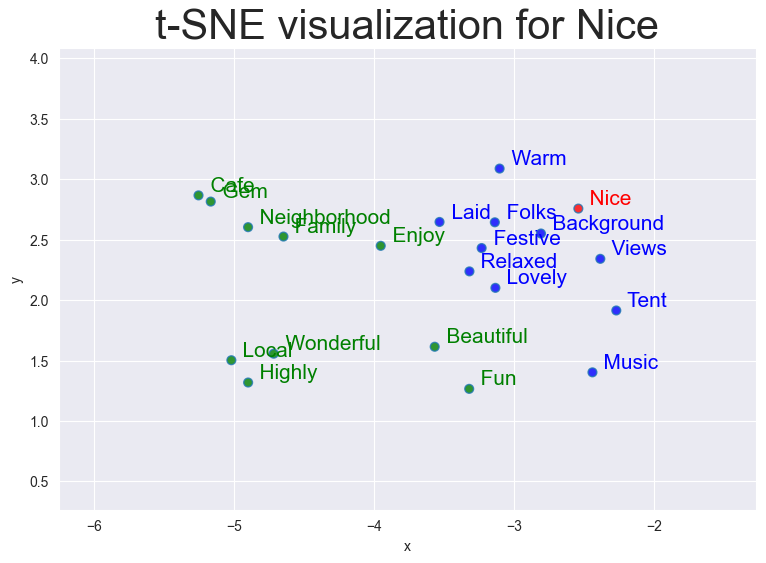

In [161]:
tsnescatterplot(w2v_model, "nice", [i[0] for i in w2v_model.wv.most_similar(positive=["great","enjoyable","happy","glad","awesome"], negative=["disgusting","price","bad"], topn=20)][10:])

In [115]:
w2v_model.wv.most_similar(positive=["great","enjoyable","happy","glad","awesome"], negative=["poor","worse","bad"])

[('highly', 0.8461833596229553),
 ('fantastic', 0.8357496857643127),
 ('local', 0.8253977298736572),
 ('wonderful', 0.8252502083778381),
 ('love', 0.8087860941886902),
 ('amazing', 0.7728143930435181),
 ('berkshire', 0.763683021068573),
 ('craft', 0.7610222697257996),
 ('delicious', 0.7605469822883606),
 ('affordable', 0.7566879391670227)]

In [116]:
def vectorize(sentence):
    words = sentence.split()
    words_vecs = [w2v_model.wv[word] for word in words if word in w2v_model.wv]
    if len(words_vecs) == 0:
        return np.zeros(100)
    words_vecs = np.array(words_vecs)
    return words_vecs.mean(axis=0)
w = np.array([vectorize(sentence) for sentence in X])
w = pd.DataFrame(w)

In [119]:
w.to_csv("./Data/vectorizedWords.csv", index=False)
w

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-0.049780,0.198176,-0.116124,-0.084262,-0.123156,-0.350300,-0.184551,0.225184,-0.206495,0.195061,...,-0.028998,0.125325,0.072074,0.020287,0.248705,-0.094210,0.243649,-0.287947,-0.022664,0.212150
1,-0.200027,0.272561,-0.042809,-0.163137,0.015619,-0.553263,0.117568,0.253456,-0.335781,0.084318,...,0.065304,0.328691,0.076776,0.065386,0.414223,-0.015073,0.299737,-0.368770,-0.172788,0.165331
2,-0.024382,0.187555,-0.304135,-0.023202,-0.126102,-0.281267,-0.412113,0.389819,-0.101396,0.308851,...,-0.045852,0.029138,0.098777,-0.035367,0.185001,-0.113733,0.270634,-0.365641,0.062763,0.361974
3,-0.026787,0.179484,-0.184614,-0.003254,-0.105441,-0.302782,-0.231256,0.277626,-0.097895,0.277824,...,-0.087722,0.146346,0.170473,-0.027398,0.224126,-0.067656,0.196867,-0.307448,0.074541,0.264773
4,-0.015868,0.145129,-0.206763,0.096442,-0.202116,-0.303237,-0.442395,0.282639,-0.130613,0.293731,...,-0.018143,-0.004198,0.099062,-0.027755,0.118736,-0.207643,0.247549,-0.336321,0.152124,0.271561
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2572,-0.144892,0.258315,-0.208910,-0.174627,0.122098,-0.358116,-0.006167,0.329633,-0.217643,0.247173,...,-0.029564,0.208284,0.238779,-0.004292,0.394257,0.047203,0.311342,-0.389330,-0.054957,0.314525
2573,-0.144892,0.258315,-0.208910,-0.174627,0.122098,-0.358116,-0.006167,0.329633,-0.217643,0.247173,...,-0.029564,0.208284,0.238779,-0.004292,0.394257,0.047203,0.311342,-0.389330,-0.054957,0.314525
2574,-0.220577,0.289808,0.099023,-0.131785,0.000760,-0.542541,0.300314,0.093053,-0.355062,-0.035806,...,0.027594,0.380370,0.035907,0.131590,0.456051,-0.094711,0.319071,-0.247637,-0.190838,0.057201
2575,-0.166086,0.231833,-0.049642,-0.085859,-0.008196,-0.427762,0.049810,0.208338,-0.268806,0.077740,...,-0.017459,0.229099,0.070061,0.054257,0.363382,-0.065039,0.266016,-0.303191,-0.106826,0.154758


In [118]:
joblib.dump(w2v_model,'./Data/w2v_model.pkl')

['./w2v_model.pkl']